In [17]:
# basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
# file work
import os
import json
# computer vision
import cv2
import torch

In [18]:
# ALL DATA
json_file = '../../data/perfect.json'  # must contain input labels
image_folder = '../../data/perfect'
mask_folder = '../../data/perfect_masks'  # can be empty to start

# SAMPLE DATA
# json_file = 'sample_data/red_lasers/sample_data.json'  # must contain input labels
# image_folder = 'sample_data/red_lasers/sample_data'
# mask_folder = 'sample_data/red_lasers/sample_data_masks'  # can be empty to start

# load data
with open(json_file, 'r') as file:
    image_data = json.load(file)

In [19]:
len(image_data)

72

In [20]:
measured_df = pd.read_csv('../../data/measured.csv')
measured_df = measured_df.dropna(subset=['PhotoID', 'Laser Width', 'BodyLength1'])

In [21]:
laser_width = dict(zip(measured_df['PhotoID'], measured_df['Laser Width']))
body_length = dict(zip(measured_df['PhotoID'], measured_df['BodyLength1']))
pix_laser = dict(zip(measured_df['PhotoID'], measured_df['PixLaser1']))
pix_length = dict(zip(measured_df['PhotoID'], measured_df['PixLength1']))

In [22]:
def draw_dots(points, ax, color):
    ax.scatter(points[:, 0], points[:, 1], color=color, s=10)

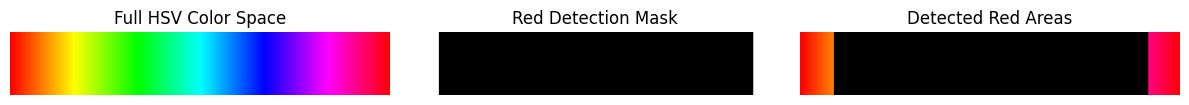

In [23]:
def plot_hsv_red_ranges():
    # Create an image with all hue values
    hsv_img = np.zeros((60, 360, 3), dtype=np.uint8)
    for i in range(360):
        hsv_img[:, i, 0] = i / 2  # Hue ranges from 0 to 180 in OpenCV
        hsv_img[:, i, 1] = 255   # Full Saturation
        hsv_img[:, i, 2] = 255   # Full Value

    # Convert to BGR for display with matplotlib
    bgr_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)

    # Define red ranges
    low_red1 = np.array([0, 120, 70])
    high_red1 = np.array([15, 255, 255])
    low_red2 = np.array([165, 120, 70])
    high_red2 = np.array([180, 255, 255])

    # Create masks for the red ranges
    red_mask1 = cv2.inRange(hsv_img, low_red1, high_red1)
    red_mask2 = cv2.inRange(hsv_img, low_red2, high_red2)
    red_mask = cv2.bitwise_or(red_mask1, red_mask2)

    # Apply masks to HSV image
    red_areas_img = cv2.bitwise_and(bgr_img, bgr_img, mask=red_mask)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(bgr_img)
    plt.title('Full HSV Color Space')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(red_mask, cmap='gray')
    plt.title('Red Detection Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(red_areas_img)
    plt.title('Detected Red Areas')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_hsv_red_ranges()

37 images with less than 10 percent error


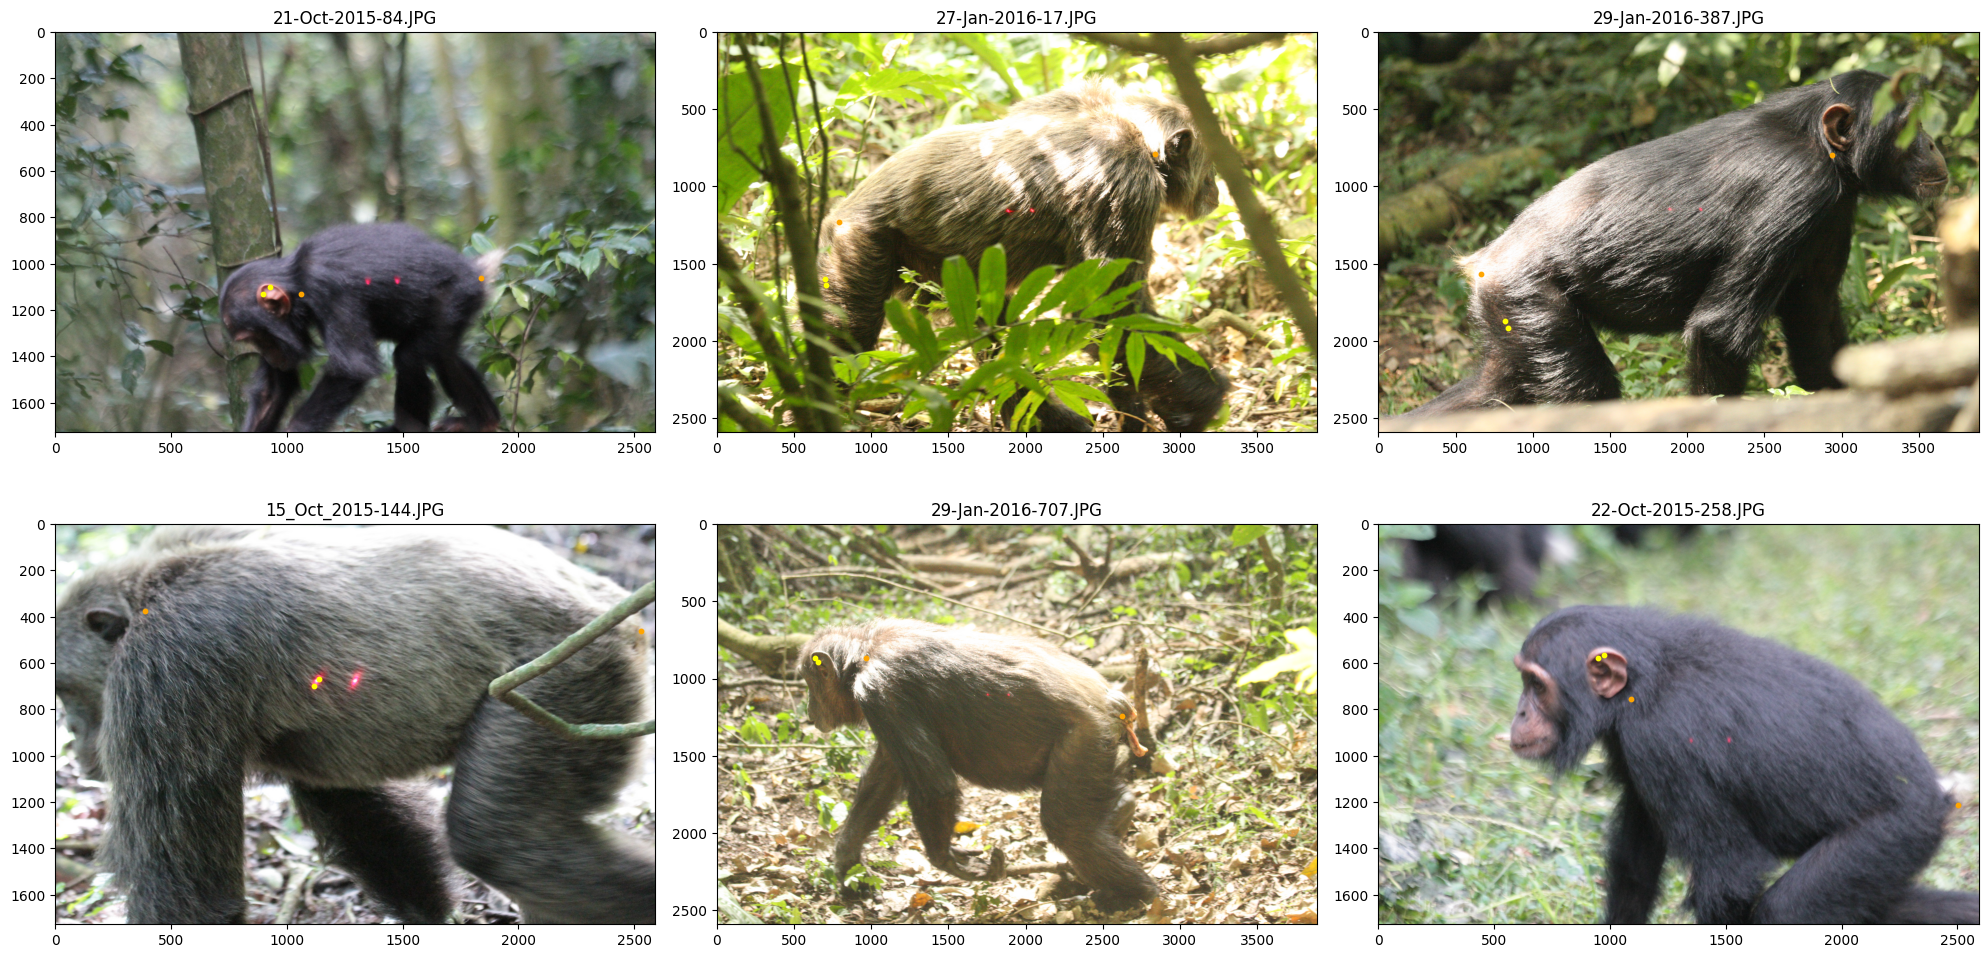

In [24]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs = axs.flatten()
idx = 0
# iterate through each entry in json
count = 0
errors = []
names = []
for image_name, info in image_data.items():
    try:
        # distances in pixels
        laser_points = info['laser_points']
        body_points = info['shoulder_rump']

        # calculate ratio
        laser_dist = round(math.dist(laser_points[0], laser_points[1]), 1)
        body_dist = round(math.dist(body_points[0], body_points[1]), 1)
        ratio = laser_dist / body_dist

        # lookup laser width
        photo_id = image_name.split('.')[0]
        laser_in = laser_width[photo_id]
        # compare results
        predicted_length = laser_in / ratio
        true_length = body_length[photo_id]
        error = round(abs(predicted_length - true_length) / true_length, 3)
        errors.append(error * 100)
        
        if error < 0.10:
            count += 1
            
        if error > 2:
            names.append(image_name)
            image_path = os.path.join(image_folder, image_name)
            # load image
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for plotting

            # plot image
            axs[idx].imshow(img)
            draw_dots(np.array(body_points), axs[idx], 'orange')
            draw_dots(np.array(laser_points), axs[idx], 'yellow')
            axs[idx].set_title(image_name)
            idx += 1
    except:
        pass

print(f"{count} images with less than 10 percent error")
plt.tight_layout()
plt.show()

In [25]:
names

['21-Oct-2015-84.JPG',
 '27-Jan-2016-17.JPG',
 '29-Jan-2016-387.JPG',
 '15_Oct_2015-144.JPG',
 '29-Jan-2016-707.JPG',
 '22-Oct-2015-258.JPG']

In [26]:
test = image_data['21-Oct-2015-84.JPG']
test

{'input_point': [1388, 962],
 'mask': '21-Oct-2015-84_mask.png',
 'laser_points': [[898, 1129], [926, 1100]],
 'shoulder_rump': [[1060, 1129], [1840, 1060]]}

In [27]:
image_path = os.path.join(image_folder, '21-Oct-2015-84.JPG')
# load image
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img.shape

(1728, 2592, 3)

In [28]:
img.shape[0]

1728

In [35]:
# Function to compute y from x using the line equation
def compute_y(x, slope, intercept):
    return int(slope * x + intercept)

# Function to create the mask with actual image dimensions
def create_geo_mask(point1, point2, image_height=1728, image_width=2592):
    # Calculate the slope and intercept of the line between the points
    dx = point2[0] - point1[0]
    dy = point2[1] - point1[1]
    slope = dy / dx if dx != 0 else None

    # Calculate the perpendicular slopes
    if slope is not None:
        perpendicular_slope = -1 / slope
        # Calculate the intercept for the perpendicular lines
        intercept1 = point1[1] - (perpendicular_slope * point1[0])
        intercept2 = point2[1] - (perpendicular_slope * point2[0])
    else:
        # If the line is vertical, the perpendiculars will be horizontal
        perpendicular_slope = 0
        intercept1 = point1[1]
        intercept2 = point2[1]

    # Create an empty mask
    mask = np.zeros((image_height, image_width), dtype=np.uint8)

    # Fill the mask
    for x in range(image_width):
        if slope is not None:
            y_from_point1 = compute_y(x, perpendicular_slope, intercept1)
            y_from_point2 = compute_y(x, perpendicular_slope, intercept2)
        else:
            # If original line is vertical, fill entire column for mask
            y_from_point1, y_from_point2 = 0, image_height - 1

        # Ensure the y values are within image boundaries
        y_from_point1 = np.clip(y_from_point1, 0, image_height - 1)
        y_from_point2 = np.clip(y_from_point2, 0, image_height - 1)

        if y_from_point1 < y_from_point2:
            mask[y_from_point1:y_from_point2, x] = 255
        else:
            mask[y_from_point2:y_from_point1, x] = 255

    return mask

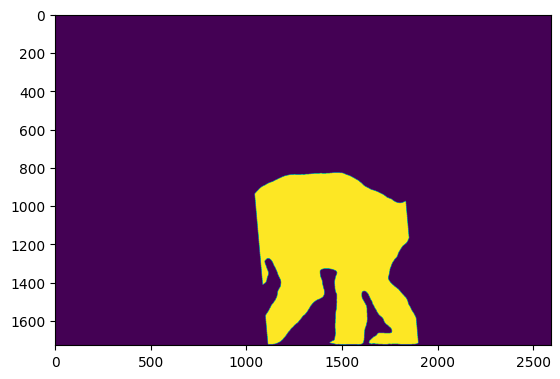

In [36]:
sr = test['shoulder_rump']
point1, point2 = sr[0], sr[1]
mask1 = create_mask(point1, point2)

mask_filename = test['mask']
mask_path = os.path.join(mask_folder, mask_filename)
mask2 = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask in grayscale

overlap_mask = cv2.bitwise_and(mask1, mask2)
plt.imshow(overlap_mask)

In [41]:
mask2.shape

(1728, 2592)

In [43]:
t = np.ones(source.shape[:2])
t.shape

(1728, 2592)

In [37]:
overlap_mask.sum()

546715

In [45]:
import sys
sys.path.append('..')
import laser_detection as ld

Laser Detection: 100%|██████████| 6/6 [00:46<00:00,  7.69s/it]


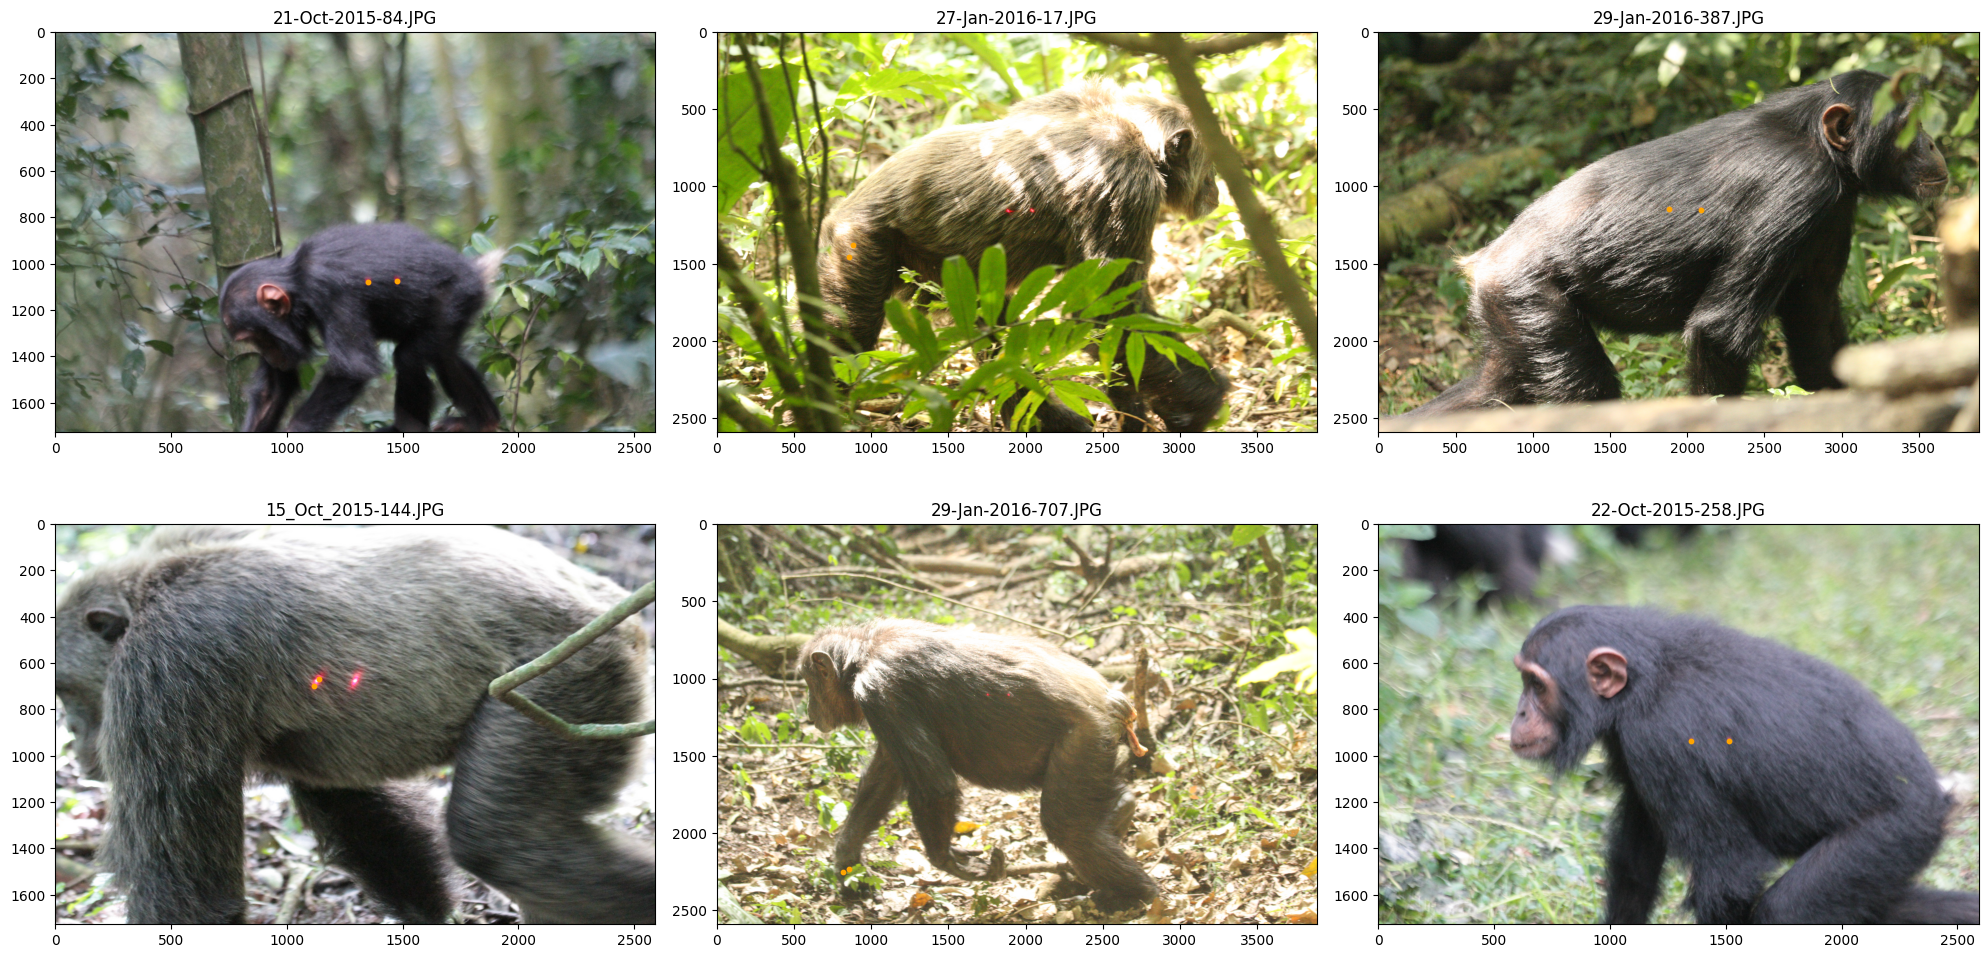

In [47]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs = axs.flatten()
idx = 0
for image_name in tqdm(names, desc='Laser Detection'):
    info = image_data[image_name]
    image_path = os.path.join(image_folder, image_name)
    
    # load image
    source = cv2.imread(image_path)

    # geo mask
    sr = info['shoulder_rump']
    if sr:
        point1, point2 = sr[0], sr[1]
        geo_mask = create_geo_mask(point1, point2, source.shape[0], source.shape[1])
    else:
        geo_mask = np.ones(source.shape)

    # body mask
    mask_filename = info['mask']
    mask_path = os.path.join(mask_folder, mask_filename)
    body_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask in grayscale

    mask = cv2.bitwise_and(geo_mask, body_mask)
    mask = mask > 0  # need to convert to boolean values

    # adjust accodringly
    laser_points = ld.detect_red_laser_points(source, mask)
    
    
    source = cv2.cvtColor(source, cv2.COLOR_BGR2RGB)
    # plot image
    axs[idx].imshow(source)
    draw_dots(np.array(laser_points), axs[idx], 'orange')
    axs[idx].set_title(image_name)
    idx += 1

plt.tight_layout()
plt.show()

In [15]:
names

['21-Oct-2015-84.JPG',
 '27-Jan-2016-17.JPG',
 '29-Jan-2016-387.JPG',
 '15_Oct_2015-144.JPG',
 '29-Jan-2016-707.JPG',
 '22-Oct-2015-258.JPG']

In [9]:
print("mean:", np.mean(errors))
print("median:", np.median(errors))
print("std:", np.std(errors))

mean: 32.96463414634146
median: 7.1499999999999995
std: 54.28375171702769


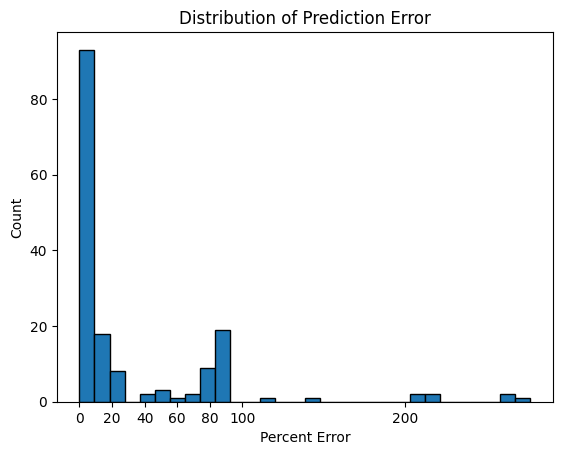

In [10]:
import matplotlib.pyplot as plt
plt.hist(errors, bins=30, edgecolor='black')
plt.xlabel("Percent Error")
plt.xticks([0,20,40,60,80,100,200])
plt.ylabel("Count")
plt.title("Distribution of Prediction Error")
plt.show()